In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report

In [2]:
df = pd.read_pickle("../data/results_prep.pkl")

In [3]:
df.head()

,date,home_team,away_team,home_score,away_score,away_elo,home_elo,tournament,home_match,result
0,1922-01-15,FRA,BEL,2,1,1300.0,1300.00,Friendly,1,1
1,1922-03-13,ENG,EUR,1,0,1300.0,1300.00,British Championship,1,1
2,1922-03-26,BEL,NED,4,0,1300.0,1295.00,Friendly,1,1
3,1922-03-26,GER,SUI,2,2,1300.0,1300.00,Friendly,1,0
4,1922-04-15,BEL,DEN,0,0,1300.0,1300.07,Friendly,1,0


In [4]:
#len(df)

In [5]:
## Features
# last result
# last 3 results
# average goals
# average goals away
# average goals opponent away
# average goals home
# average goals opponent home
# direct comparison
# elo score

In [6]:
df["match"] = df.apply(lambda r: "-".join(sorted([r["home_team"], r["away_team"]])), axis=1)

In [7]:
home_matches = (df[["date","home_team", "away_team", "home_score", "home_elo", "away_elo", "home_match", "result", "match"]]
                 .rename(columns={"home_team":"team","away_team":"opponent", "home_elo":"elo", "away_elo":"opponent_elo","home_score":"score"}))

away_matches = (df[["date","away_team", "home_team","away_score", "home_elo", "away_elo", "home_match", "result", "match"]]
                 .rename(columns={"away_team":"team","home_team":"opponent", "away_elo":"elo", "home_elo":"opponent_elo","away_score":"score"}))

away_matches["result"] = away_matches["result"]*-1
away_matches["home_match"] = (away_matches["home_match"]==0).astype(int)

In [8]:
results_long = (home_matches.append(away_matches)
                            .sort_values(["date","match"])
                            .reset_index(drop=True))

In [9]:
df.tail(1)

,date,home_team,away_team,home_score,away_score,away_elo,home_elo,tournament,home_match,result,match
3722,2022-03-29,NED,GER,1,1,1432.13,1462.325,Friendly,1,0,GER-NED


In [10]:
results_long[(results_long["date"]=="2022-03-29") & (results_long["match"]=="GER-NED")]

,date,team,opponent,score,elo,opponent_elo,home_match,result,match
7444,2022-03-29,NED,GER,1,1462.325,1432.130,1,0,GER-NED
7445,2022-03-29,GER,NED,1,1432.130,1462.325,0,0,GER-NED


In [11]:
results_long[results_long["team"]=="BEL"].head()

,date,team,opponent,score,elo,opponent_elo,home_match,result,match
1,1922-01-15,BEL,FRA,1,1300.00,1300.00,0,-1,BEL-FRA
4,1922-03-26,BEL,NED,4,1295.00,1300.00,1,1,BEL-NED
8,1922-04-15,BEL,DEN,0,1300.07,1300.00,1,0,BEL-DEN
15,1922-05-07,BEL,NED,2,1300.07,1300.00,0,1,BEL-NED
36,1923-02-04,BEL,ESP,1,1305.07,1314.86,1,1,BEL-ESP


In [12]:
def prepare_features(df, pfx=""):

    df[f"last_result{pfx}"] = df.groupby(["team"])["result"].apply(lambda r: r.shift())
    df[f"last3_result{pfx}"] = df.groupby(["team"])["result"].apply(lambda r: r.shift().rolling(3).mean())
    df[f"ewm_score{pfx}"] = df.groupby("team")["score"].apply(lambda r: r.shift().ewm(span=10).mean())
    
    df[f"last_result_opponent{pfx}"] = df.groupby(["opponent"])["result"].apply(lambda r: r.shift())
    df[f"last3_result_opponent{pfx}"] = df.groupby(["opponent"])["result"].apply(lambda r: r.shift().rolling(3).mean())
    df[f"ewm_score_opponent{pfx}"] = df.groupby("opponent")["score"].apply(lambda r: r.shift().ewm(span=10).mean())
    
    df[f"last_result_diff{pfx}"] = df[f"last_result{pfx}"] - df[f"last_result_opponent{pfx}"]
    df[f"last3_result_diff{pfx}"] = df[f"last3_result{pfx}"] - df[f"last3_result_opponent{pfx}"]
    df[f"ewm_score_diff{pfx}"] = df[f"ewm_score{pfx}"] - df[f"ewm_score_opponent{pfx}"]
    
    df[f"elo_diff{pfx}"] = df[f"elo{pfx}"] - df[f"opponent_elo{pfx}"]
    
#     df[f"last_result_direct{pfx}"] = df.groupby(["match"])["result"].apply(lambda r: r.shift())
#     df[f"last3_result_direct{pfx}"] = df.groupby(["match"])["result"].apply(lambda r: r.shift().rolling(3).mean())
    
    return df    

In [13]:
results_long = prepare_features(results_long)

In [14]:
results_long[results_long["team"]=="BEL"].head()

,date,team,opponent,score,elo,opponent_elo,home_match,result,match,last_result,last3_result,ewm_score,last_result_opponent,last3_result_opponent,ewm_score_opponent,last_result_diff,last3_result_diff,ewm_score_diff,elo_diff
1,1922-01-15,BEL,FRA,1,1300.00,1300.00,0,-1,BEL-FRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
4,1922-03-26,BEL,NED,4,1295.00,1300.00,1,1,BEL-NED,-1.0,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,-5.00
8,1922-04-15,BEL,DEN,0,1300.07,1300.00,1,0,BEL-DEN,1.0,NaN,2.650000,NaN,NaN,NaN,NaN,NaN,NaN,0.07
15,1922-05-07,BEL,NED,2,1300.07,1300.00,0,1,BEL-NED,0.0,0.000000,1.584718,-1.0,NaN,1.800000,1.0,NaN,-0.215282,0.07
36,1923-02-04,BEL,ESP,1,1305.07,1314.86,1,1,BEL-ESP,1.0,0.666667,1.721535,-1.0,-1.0,0.328904,2.0,1.666667,1.392631,-9.79


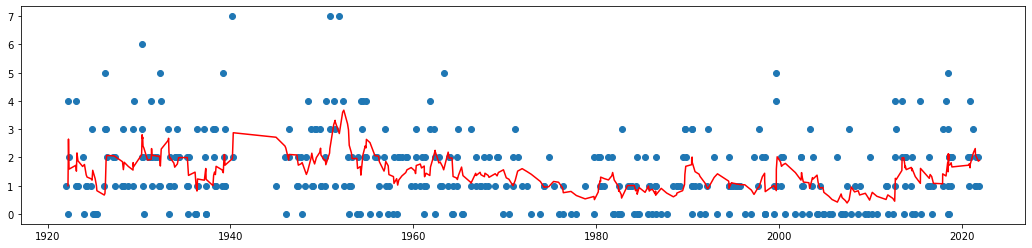

In [15]:
plt.figure(figsize=(18,4))
sample = results_long[results_long["team"]=="BEL"]
plt.scatter(sample["date"], sample["score"])
plt.plot(sample["date"], sample["ewm_score"], color="red")
#plt.legend()
plt.show()

In [16]:
results_long.tail()

,date,team,opponent,score,elo,opponent_elo,home_match,result,match,last_result,last3_result,ewm_score,last_result_opponent,last3_result_opponent,ewm_score_opponent,last_result_diff,last3_result_diff,ewm_score_diff,elo_diff
7441,2022-03-29,ARG,ECU,1,1471.465,1219.345,0,0,ARG-ECU,0.0,0.666667,1.429800,0.0,-0.333333,1.615859,0.0,1.000000,-0.186059,252.120
7442,2022-03-29,DEN,SRB,3,1332.670,1234.535,1,1,DEN-SRB,-1.0,-0.333333,1.639087,-1.0,-1.000000,1.227783,0.0,0.666667,0.411303,98.135
7443,2022-03-29,SRB,DEN,0,1234.535,1332.670,0,-1,DEN-SRB,1.0,1.000000,2.082859,1.0,0.333333,1.795172,0.0,0.666667,0.287687,-98.135
7444,2022-03-29,NED,GER,1,1462.325,1432.130,1,0,GER-NED,1.0,0.666667,1.986815,1.0,0.333333,2.067902,0.0,0.333333,-0.081086,30.195
7445,2022-03-29,GER,NED,1,1432.130,1462.325,0,0,GER-NED,-1.0,-0.333333,1.320958,-1.0,-0.666667,1.259675,0.0,0.333333,0.061283,-30.195


In [17]:
# home = results_long[results_long["home_match"]==1].copy()
# away = results_long[results_long["home_match"]==0].copy()

In [18]:
# home = prepare_features(home, pfx="_home")
# away = prepare_features(away, pfx="_away")

In [19]:
#away[away["team"]=="BEL"]

In [20]:
# data_prep = (home.append(away)
#              .sort_values("date")
#              .reset_index(drop=True))

In [21]:
results_long.to_pickle("../data/data_prep.pkl")